In [1]:
# import all necessary libraries
import glob, warnings, random, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.models import VGG19_Weights, EfficientNet_V2_L_Weights

from PIL import Image
from typing import Dict, List, Tuple
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from datasets_supervised import BrainTumorMRIDataset

In [2]:
warnings.filterwarnings("ignore")

In [3]:
class CFG:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    NUM_DEVICES = torch.cuda.device_count()
    NUM_WORKERS = os.cpu_count()
    NUM_CLASSES = 4
    EPOCHS = 16
    BATCH_SIZE = (
        32 if torch.cuda.device_count() < 2 
        else (32 * torch.cuda.device_count())
    )
    LR = 0.001
    APPLY_SHUFFLE = True
    SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)
    
    # Define paths
    DATASET_PATH = './data/original/'
    TRAIN_PATH = './data/original//Training/'
    TEST_PATH = './data/original/Testing/'

In [4]:
train_images = glob.glob(f"{CFG.TRAIN_PATH}**/*.jpg")
test_images = glob.glob(f"{CFG.TEST_PATH}**/*.jpg")

In [5]:
def generate_labels(image_paths):
    return [(_.split('/')[-2:][0]).replace('-', '_') for _ in image_paths]

def build_df(image_paths, labels):
    df = pd.DataFrame({'image_path': image_paths, 'label': generate_labels(labels)})
    return df

def _load(image_path, as_tensor=True, target_size=(224,224)):
    image = Image.open(image_path)
    image = image.resize(target_size)
    image = image.convert('RGB')
    if as_tensor:
        converter = transforms.Compose([transforms.ToTensor(), transforms.Grayscale()])
        return converter(image)
    else:
        return image

In [6]:
train_df = build_df(train_images, generate_labels(train_images))
test_df = build_df(test_images, generate_labels(test_images))

In [7]:
train_df_sample = train_df.sample(frac=0.10, random_state=42).reset_index(drop=True)
train_split_idx, val_split_idx, _, _ = (train_test_split(
    train_df_sample.index,
    train_df_sample.label,
    test_size=0.20, 
    stratify=train_df_sample.label,
    random_state=CFG.SEED))

In [8]:
train_new_df = train_df_sample.iloc[train_split_idx].reset_index(drop=True)
val_df = train_df_sample.iloc[val_split_idx].reset_index(drop=True)
train_new_df.shape, val_df.shape

((456, 2), (115, 2))

In [9]:
train_new_df

,image_path,label
0,./data/original//Training/pituitary/Tr-pi_1405...,pituitary
1,./data/original//Training/glioma/Tr-gl_0772.jpg,glioma
2,./data/original//Training/glioma/Tr-gl_1055.jpg,glioma
3,./data/original//Training/pituitary/Tr-pi_1305...,pituitary
4,./data/original//Training/notumor/Tr-no_0347.jpg,notumor
...,...,...
451,./data/original//Training/notumor/Tr-no_1319.jpg,notumor
452,./data/original//Training/pituitary/Tr-pi_0883...,pituitary
453,./data/original//Training/glioma/Tr-gl_1286.jpg,glioma
454,./data/original//Training/glioma/Tr-gl_0093.jpg,glioma


In [10]:
train_size = len(train_new_df)
val_size = len(val_df)
test_size = len(test_df)
total = train_size + val_size

# View the counts
print(f'train samples count:\t\t{train_size}\t({(100 * train_size/total):.2f}%)')
print(f'validation samples count:\t{val_size}\t({(100 * val_size/total):.2f}%)')
print('================================================')
print(f'TOTAL:\t\t\t\t{total}\t({(100 * total/total):.2f}%)')

print('')
print(f'INDEPENDENT test samples count:\t\t{test_size}\t')

train samples count:		456	(79.86%)
validation samples count:	115	(20.14%)
TOTAL:				571	(100.00%)

INDEPENDENT test samples count:		1311	


In [11]:
train_transforms = transforms.Compose([
    transforms.Resize((CFG.HEIGHT, CFG.WIDTH)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize((CFG.HEIGHT, CFG.WIDTH)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])
idx = random.sample(train_df_sample.index.to_list(), 1)[0]
aug_image = _load(train_df_sample.image_path[idx], as_tensor=False)

In [12]:
# Create datasets and dataloaders
train_ds = BrainTumorMRIDataset(train_new_df, transform=train_transforms)
val_ds = BrainTumorMRIDataset(val_df, transform=test_transforms)
test_ds = BrainTumorMRIDataset(test_df, transform=test_transforms)

In [13]:
train_loader = DataLoader(
    dataset=train_ds, 
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=CFG.APPLY_SHUFFLE,
)
val_loader = DataLoader(
    dataset=val_ds,
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=False
)
test_loader = DataLoader(
    dataset=test_ds,
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=False
)

## **ORIGINAL MODEL**

### Defining and Training the EfficientNetV2 Model

In [14]:
class EfficientNetV2Model(nn.Module):
    def __init__(self, backbone_model, name='efficientnet-v2-large', 
                 num_classes=CFG.NUM_CLASSES, device=CFG.DEVICE):
        super(EfficientNetV2Model, self).__init__()
        
        self.backbone_model = backbone_model
        self.device = device
        self.num_classes = num_classes
        self.name = name
        
        classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2, inplace=True), 
            nn.Linear(in_features=1280, out_features=256, bias=True),
            nn.GELU(),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features=256, out_features=num_classes, bias=False)
        ).to(device)
        
        self._set_classifier(classifier)
        
    def _set_classifier(self, classifier:nn.Module) -> None:
        self.backbone_model.classifier = classifier

    def set_params(self, **params):
        for param_name, param_value in params.items():
            setattr(self, param_name, param_value)
    
    def forward(self, image):
        return self.backbone_model(image)

    def fit(self, train_loader, val_loader, optimizer, loss_fn, epochs):
        train_loss_history = []
        val_loss_history = []
        
        for epoch in range(epochs):
            train_loss = 0.0
            val_loss = 0.0
            
            # Training
            self.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                output = self(data)
                loss = loss_fn(output, target)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * data.size(0)
            train_loss /= len(train_loader.dataset)
            train_loss_history.append(train_loss)
            
            # Validation
            self.eval()
            for batch_idx, (data, target) in enumerate(val_loader):
                data, target = data.to(self.device), target.to(self.device)
                output = self(data)
                loss = loss_fn(output, target)
                val_loss += loss.item() * data.size(0)
            val_loss /= len(val_loader.dataset)
            val_loss_history.append(val_loss)
            print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}')
        return train_loss_history, val_loss_history

In [15]:
def get_efficientnetv2_model(
    device: torch.device=CFG.NUM_CLASSES) -> nn.Module:
    torch.manual_seed(CFG.SEED)
    torch.cuda.manual_seed(CFG.SEED)
    model_weights = (
        torchvision
        .models
        .EfficientNet_V2_L_Weights
        .DEFAULT)
    model = (torchvision.models.efficientnet_v2_l(weights=model_weights)).to(device) 
    for param in model.features.parameters():
        param.requires_grad = False 
    return model

In [16]:
backbone_model = get_efficientnetv2_model(CFG.DEVICE)
efficientnetv2_params = {
    'backbone_model'    : backbone_model,
    'name'              : 'efficientnet-v2-large',
    'device'            : CFG.DEVICE}
efficientnet_model = EfficientNetV2Model(**efficientnetv2_params)

In [17]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(efficientnet_model.parameters(), lr=CFG.LR)

In [18]:
def execute_epoch(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:
    
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 
        
        # Gradients & Backpropagate Loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Compute Batch Metrics
        predicted_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (predicted_class == y).sum().item() / len(y_pred)
        
    # Compute Step Metrics
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    return train_loss, train_acc

In [19]:
def evaluate(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:
    
    model.eval()
    eval_loss, eval_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            eval_loss += loss.item()
            predicted_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            eval_acc += (predicted_class == y).sum().item() / len(y_pred)

    eval_loss = eval_loss / len(dataloader)
    eval_acc = eval_acc / len(dataloader)
    return eval_loss, eval_acc

In [20]:
def train(
    model:torch.nn.Module,
    train_dataloader:torch.utils.data.DataLoader,
    eval_dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    epochs:int,
    device:torch.device) -> Dict[str, List]:
    
    session = {
        'loss'          : [],
        'accuracy'      : [],
        'eval_loss'     : [],
        'eval_accuaracy': []}
    
    for epoch in tqdm(range(epochs)):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        train_loss, train_acc = execute_epoch(
            model, 
            train_dataloader, 
            optimizer, 
            loss_fn, 
            device)
        eval_loss, eval_acc = evaluate(
            model, 
            eval_dataloader,
            loss_fn, 
            device)
        print(f'loss: {train_loss:.4f} - acc: {train_acc:.4f} - eval_loss: {eval_loss:.4f} - eval_acc: {eval_acc:.4f}')
        session['loss'].append(train_loss)
        session['accuracy'].append(train_acc)
        session['eval_loss'].append(eval_loss)
        session['eval_accuaracy'].append(eval_acc)
    return session

### Original Training of Model (with no Fine-Tuning)

In [21]:
print('Training EfficientNet Model')
print(f'Train on {len(train_new_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')
efficientnet_session_config = {
    'model'               : efficientnet_model,
    'train_dataloader'    : train_loader,
    'eval_dataloader'     : val_loader,
    'optimizer'           : optimizer,
    'loss_fn'             : loss_fn,
    'epochs'              : CFG.EPOCHS,
    'device'              : CFG.DEVICE
}
efficientnet_session_history = train(**efficientnet_session_config)

Training EfficientNet Model
Train on 456 samples, validate on 115 samples.
----------------------------------


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch 1/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 1.1668 - acc: 0.5437 - eval_loss: 1.0712 - eval_acc: 0.5637

Epoch 2/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.8154 - acc: 0.7875 - eval_loss: 0.9447 - eval_acc: 0.6731

Epoch 3/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.7709 - acc: 0.7875 - eval_loss: 0.7713 - eval_acc: 0.8092

Epoch 4/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.6942 - acc: 0.8271 - eval_loss: 0.6829 - eval_acc: 0.8458

Epoch 5/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.6800 - acc: 0.8438 - eval_loss: 0.6624 - eval_acc: 0.8668

Epoch 6/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.6714 - acc: 0.8521 - eval_loss: 0.6789 - eval_acc: 0.8746

Epoch 7/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.7139 - acc: 0.8167 - eval_loss: 0.6298 - eval_acc: 0.8902

Epoch 8/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.7175 - acc: 0.8292 - eval_loss: 0.6418 - eval_acc: 0.8746

Epoch 9/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.7632 - acc: 0.7896 - eval_loss: 0.6378 - eval_acc: 0.8746

Epoch 10/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.6525 - acc: 0.8604 - eval_loss: 0.6595 - eval_acc: 0.8458

Epoch 11/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.6517 - acc: 0.8542 - eval_loss: 0.6123 - eval_acc: 0.8746

Epoch 12/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.5932 - acc: 0.9000 - eval_loss: 0.6338 - eval_acc: 0.8824

Epoch 13/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.6165 - acc: 0.8646 - eval_loss: 0.6334 - eval_acc: 0.8668

Epoch 14/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.6172 - acc: 0.8896 - eval_loss: 0.6181 - eval_acc: 0.8824

Epoch 15/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.5637 - acc: 0.9146 - eval_loss: 0.6482 - eval_acc: 0.8824

Epoch 16/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.6135 - acc: 0.8833 - eval_loss: 0.5909 - eval_acc: 0.8849


### Evaluate the Original Model
We will be looking at accuracy and evaluation losses, a confusion matrix (matching true and predicted labels), and the accuracy score.

In [22]:
def predict(
    model:nn.Module, 
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device) -> np.ndarray:
    model.eval() 
    predictions = []
    with torch.inference_mode():
        for batch, (X, y) in enumerate(tqdm(sample_loader)):
            X, y = X.to(device), y.to(device)
            y_pred = model(X) 
            predicted_probs = torch.softmax(y_pred, dim=1).cpu().numpy()
            predictions.append(predicted_probs) 
    return np.vstack(predictions)

In [23]:
efficientnet_test_probs = predict(efficientnet_model, test_loader, CFG.DEVICE)

  0%|          | 0/41 [00:00<?, ?it/s]

In [24]:
def plot_training_curves(history):
    loss = np.array(history['loss'])
    accuracy = np.array(history['accuracy'])
    val_loss = np.array(history['eval_loss'])
    val_accuracy = np.array(history['eval_accuaracy'])
    epochs = range(len(history['loss']))

    # Plot loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='eval_loss', marker='o')
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)
    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='eval_accuracy', marker='o')
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)
    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();
    
    sns.despine();
    return

In [25]:
efficientnet_session_history_df = pd.DataFrame(efficientnet_session_history)
efficientnet_session_history_df

,loss,accuracy,eval_loss,eval_accuaracy
0,1.166783,0.543750,1.071176,0.563734
1,0.815438,0.787500,0.944709,0.673109
2,0.770866,0.787500,0.771332,0.809211
3,0.694151,0.827083,0.682944,0.845806
4,0.680025,0.843750,0.662430,0.866776
5,0.671421,0.852083,0.678861,0.874589
6,0.713905,0.816667,0.629790,0.890214
7,0.717515,0.829167,0.641770,0.874589
8,0.763169,0.789583,0.637804,0.874589
9,0.652453,0.860417,0.659522,0.845806


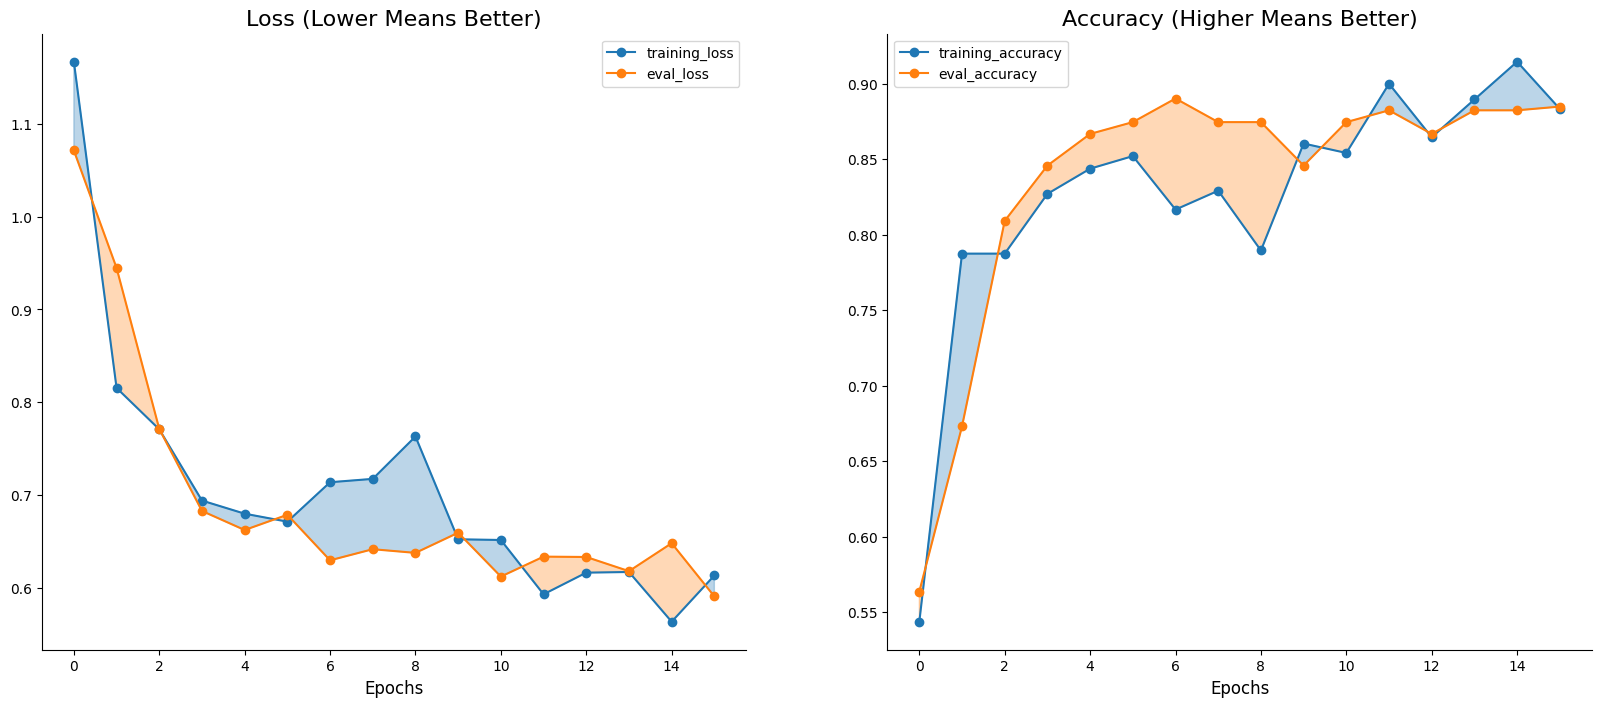

In [26]:
plot_training_curves(efficientnet_session_history)

In [27]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12): 
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    disp = sns.heatmap(cm, annot=True, cmap='OrRd', annot_kws={"size": text_size}, fmt='g',
        linewidths=0.5, linecolor='black', clip_on=False, xticklabels=classes, yticklabels=classes)
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20) 
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0) 
    plt.show()
    return

In [28]:
test_labels = [*map(test_ds.class_to_idx.get, test_ds.labels)]
print(test_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [29]:
efficientnet_test_preds = np.argmax(efficientnet_test_probs, axis=1)
print(efficientnet_test_preds)

[0 1 0 ... 2 2 2]


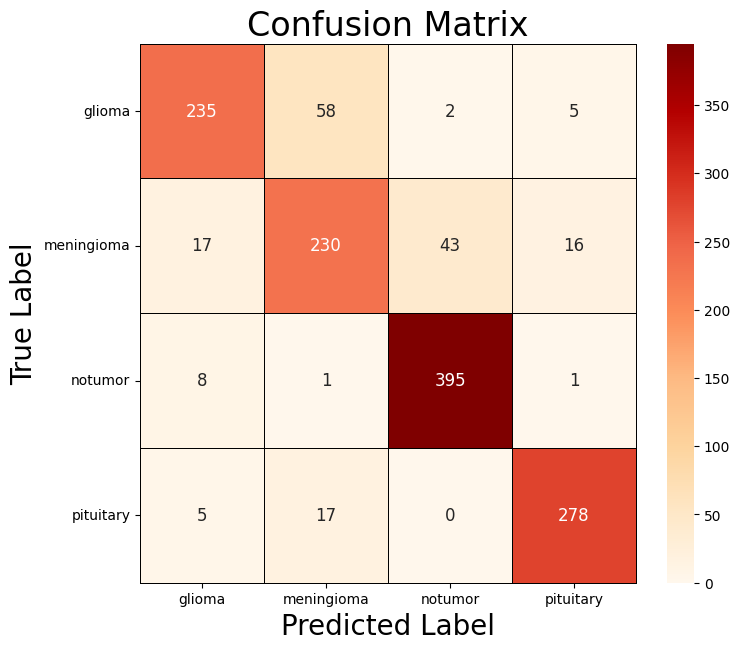

In [30]:
plot_confusion_matrix(test_labels, efficientnet_test_preds, figsize=(8,7), classes=test_ds.classes)

In [31]:
accuracy_score(test_labels, efficientnet_test_preds)

0.8680396643783371

## **Hyperparameter tuning with GridSearchCV**

GridSearchCV expects numpy arrays or similar objects for X and y, not PyTorch DataLoaders. We'll transform the data into a format that GridSearchCV can understand, but creating a function that converts a DataLoader to numpy array for X and y.

In [32]:
class NumpyDataset(Dataset):
    def __init__(self, X, y=None, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = self.X[idx]
        if self.transform:
            sample = self.transform(sample)
        if self.y is not None:
            return sample, self.y[idx]
        else:
            return sample

In [33]:
def dataloader_to_numpy(dataloader):
    X_list = []
    y_list = []
    for data, targets in dataloader:
        X_list.append(data.numpy())
        y_list.append(targets.numpy())
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y

In [34]:
# Convert train and validation DataLoader to numpy arrays
X_train, y_train = dataloader_to_numpy(train_loader)
X_val, y_val = dataloader_to_numpy(val_loader)

GridSearchCV expects the model to follow scikit-learn's interface, which means we won't be able to use the above PyTorch model. As such, we will create a wrapper class for the PyTorch model such that it adheres to the scikit-learn estimator interface.

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import make_scorer

In [36]:
class SklearnWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, num_classes=CFG.NUM_CLASSES, dropout_rate=0.2, weight_decay=0.01, momentum=0.9, lr=0.001, device=CFG.DEVICE):
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        self.weight_decay = weight_decay
        self.momentum = momentum
        self.lr = lr
        self.device = device
        self.model = self._initialize_model()
        self.loss_fn = nn.CrossEntropyLoss()

    def _initialize_model(self):
        model = torchvision.models.efficientnet_v2_l(weights=EfficientNet_V2_L_Weights.DEFAULT)
        model.classifier = nn.Sequential(
            nn.Dropout(p=self.dropout_rate, inplace=True),
            nn.Linear(model.classifier[1].in_features, self.num_classes)
        ).to(self.device)
        return model

    def fit(self, X, y):
        X_tensor = torch.tensor(X).float().to(self.device)
        y_tensor = torch.tensor(y).long().to(self.device)
        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=CFG.BATCH_SIZE, shuffle=True)
        optimizer = optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)

        self.model.train()
        for epoch in range(CFG.EPOCHS):
            running_loss = 0
            correct = 0
            total = 0
            for data, targets in dataloader:
                optimizer.zero_grad()
                outputs = self.model(data)
                loss = self.loss_fn(outputs, targets)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
            print(f'Epoch {epoch+1}/{CFG.EPOCHS}, Loss: {running_loss/len(dataloader):.4f}, Accuracy: {100.*correct/total:.2f}%')
        return self

    def predict(self, X):
        X_tensor = torch.tensor(X).float().to(self.device)
        dataset = TensorDataset(X_tensor)
        dataloader = DataLoader(dataset, batch_size=CFG.BATCH_SIZE, shuffle=False)
        
        self.model.eval()
        preds = []
        with torch.no_grad():
            for data in dataloader:
                outputs = self.model(data[0])
                _, predicted = outputs.max(1)
                preds.append(predicted.cpu().numpy())
        return np.concatenate(preds)

    def score(self, X, y):
        X_tensor = torch.tensor(X).float().to(self.device)
        y_tensor = torch.tensor(y).long().to(self.device)
        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=CFG.BATCH_SIZE, shuffle=False)
        
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, targets in dataloader:
                outputs = self.model(data[0])
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        return 100. * correct / total

In [37]:
# Define your parameter grid
param_grid = {
    'dropout_rate': [0.0, 0.1, 0.2],
    'weight_decay': [0.0, 0.001, 0.01],
    'momentum': [0.9, 0.95],
    'lr': [1e-4, 1e-3, 1e-2]}

Above, I have listed out a the parameters I want to explore and fine-tune. Below, I will discuss what they and the respective values I have picked mean:
1. **dropout_rate:** Dropout is a regularization technique used to prevent overfitting in neural networks. It randomly drops a fraction of the neurons during training, forcing the network to learn more robust features. The dropout_rate parameter controls the probability of dropping neurons during training. A value of 0.0 means no dropout, while values closer to 1.0 mean more aggressive dropout.
2. **weight_decay:** Weight decay, also known as L2 regularization, is a regularization technique that penalizes large weights in the model. It adds a term to the loss function proportional to the squared magnitude of the weights. The weight_decay parameter controls the strength of this penalty. A value of 0.0 means no weight decay, while higher values impose stronger regularization by penalizing larger weights more.
3. **momentum:** Momentum is a parameter used in optimization algorithms like SGD (Stochastic Gradient Descent) with momentum and variants like Adam. It helps accelerate gradients in the right direction and dampens oscillations. The momentum parameter controls the momentum term in the optimization algorithm. A value close to 1.0 means higher momentum, which helps in faster convergence, while values closer to 0.0 mean less momentum.
4. **lr (learning rate):** The learning rate is one of the most crucial hyperparameters in training neural networks. It determines the step size taken during optimization to update the weights of the network. The lr parameter controls the learning rate used in the optimization algorithm. Lower values lead to slower but more precise convergence, while higher values can speed up convergence but risk overshooting the minimum of the loss function.

I'm trying to find the right balance between model capacity (dropout_rate), regularization (weight_decay), optimization stability (momentum), and convergence speed (learning rate) to achieve a better performance on my dataset without overfitting.

In [38]:
# Initialize the model and optimizer outside the loop
# backbone_model = torchvision.models.efficientnet_v2_l(weights=EfficientNet_V2_L_Weights.DEFAULT)

In [ ]:
model = SklearnWrapper(num_classes=CFG.NUM_CLASSES, device=CFG.DEVICE)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')
tqdm(grid_search.fit(X_train, y_train))

Epoch 1/16, Loss: 1.0050, Accuracy: 59.21%
Epoch 2/16, Loss: 0.2892, Accuracy: 95.07%
Epoch 3/16, Loss: 0.1514, Accuracy: 97.04%
Epoch 4/16, Loss: 0.0595, Accuracy: 99.01%
Epoch 5/16, Loss: 0.0570, Accuracy: 98.68%
Epoch 6/16, Loss: 0.0232, Accuracy: 100.00%


In [ ]:
# Evaluate the best model
best_model = grid_search.best_estimator_
print("Best Parameters: ", grid_search.best_params_)

In [ ]:
# Evaluate the best model
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Best Model Test Accuracy:", test_accuracy)

In [ ]:
grid_search.get_params().keys()